# Evaluating the impact of the geometry on HPL performance

In [1]:
import io
import zipfile
import os
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import yaml
import warnings
from statsmodels.formula.api import ols
from numpy import log, mean, std

warnings.simplefilter(action='ignore')

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def get_platform(archive_name):
    info = get_yaml(archive_name, 'info.yaml')
    expfiles = info['expfile']
    platform = [f for f in expfiles if f.endswith('xml')]
    assert len(platform) == 1
    return platform[0]

def read_csv(archive_name, file_name):
    archive = zipfile.ZipFile(archive_name)
    res = pandas.read_csv(io.BytesIO(archive.read(file_name)))
    res['filename'] = archive_name
    return res

def read_result(name):
    res = read_csv(name, 'results.csv')
    res['start_timestamp'] = pandas.to_datetime(res['start_timestamp'])
    res['start'] = res['start_timestamp'] - res['start_timestamp'].min()
    return res

def read_sim_result(name):
    archive = zipfile.ZipFile(name)
    result = pandas.read_csv(io.BytesIO(archive.read('results.csv')))
    result['platform'] = get_platform(name)
    result['filename'] = name
    return result

simulation_dir = 'geometry/1/'
simulation_files = [os.path.join(simulation_dir, f) for f in os.listdir(simulation_dir) if f.endswith('.zip')]

df = pandas.concat([read_sim_result(f) for f in simulation_files])
df['nb_nodes'] = df['proc_p'] * df['proc_q']
df['geometry'] = df['proc_p'].astype(str) + '×' + df['proc_q'].astype(str)
df.head()

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,...,application_time,usr_time,sys_time,major_page_fault,minor_page_fault,cpu_utilization,platform,filename,nb_nodes,geometry
0,200000,512,3,11,1,2,2,1,0,8,...,20.0117,79.59,47.28,0,37239584,1.04,dahu_synthetic.xml,geometry/1/grenoble_2020-04-07_1925016.zip,33,3×11
1,200000,512,4,6,1,2,2,1,0,8,...,27.6208,123.79,135.90,0,95776861,1.01,dahu_synthetic.xml,geometry/1/grenoble_2020-04-07_1925016.zip,24,4×6
2,200000,512,12,9,1,2,2,1,0,8,...,84.1962,347.31,284.71,0,176692789,1.00,dahu_synthetic.xml,geometry/1/grenoble_2020-04-07_1925016.zip,108,12×9
3,200000,512,4,5,1,2,2,1,0,8,...,26.3604,120.42,135.07,0,96408652,1.01,dahu_synthetic.xml,geometry/1/grenoble_2020-04-07_1925016.zip,20,4×5
4,200000,512,12,1,1,2,2,1,0,8,...,64.0564,327.72,286.22,0,180986772,1.00,dahu_synthetic.xml,geometry/1/grenoble_2020-04-07_1925016.zip,12,12×1


### Checking the parameters

In [2]:
name_exceptions = {'application_time', 'simulation_time', 'usr_time', 'sys_time', 'time', 'gflops', 'residual', 'cpu_utilization',
                   'dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept',
                   'stochastic_cpu', 'polynomial_dgemm', 'stochastic_network', 'heterogeneous_dgemm', 'platform', 'model', 'filename',
                   'simulation', 'slow_nodes',
                   'major_page_fault', 'minor_page_fault', 'matrix_size', 'mode',
                   'start_timestamp', 'stop_timestamp'}
colnames = set(df) - name_exceptions

In [3]:
df.groupby(list(colnames))[['swap']].count()

swap
proc_q depth process_per_node mem_align geometry nb_nodes swap thread_per_process pfact proc_p block_size bcast rfact      
1      1     1                8         10×1     10       0    1                  1     10     512        2     2         1
                                        11×1     11       0    1                  1     11     512        2     2         1
                                        128×1    128      0    1                  1     128    512        2     2         1
                                        12×1     12       0    1                  1     12     512        2     2         1
                                        144×1    144      0    1                  1     144    512        2     2         1
...                                                                                                                     ...
64     1     1                8         1×64     64       0    1                  1     1      512        2     2         1
                                        2×64     128      0    1                  1     2      512        2     2         1
72     1     1                8         2×72     144      0    1                  1     2      512        2     2         1
128    1     1                8         1×128    128      0    1                  1     1      512        2     2         1
144    1     1                8         1×144    144      0    1                  1     1      512        2     2         1

[168 rows x 1 columns]

In [4]:
from IPython.display import display, Markdown

platforms = [(get_platform(f), zipfile.ZipFile(f).read(get_platform(f)).decode('ascii')) for f in simulation_files]
platforms = list(set(platforms))
assert(len(platforms)) == 1
for name, plat in platforms:
    display(Markdown('### %s' % name))
    display(Markdown('```xml\n%s\n```' % plat))

### dahu_synthetic.xml

```xml
<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.965491847282898e-07:9.63619592297199e-11;8133:4.117386759387727e-06:9.998650637323814e-11;15831:3.901910334928982e-06:1.1003492469181915e-10;33956:8.556208528368661e-06:1.2636592924112397e-10;64000:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375236e-06:8.456019002037162e-11;8133:1.0616877366305338e-06:1.0399801951417905e-10;15831:1.1989168715510673e-06:9.880880432093221e-11;33956:1.3028804423006338e-06:1.0742263180618875e-10;64000:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.931229521083401e-07:7.051204536228214e-11;8133:3.601990790153244e-07:1.2449128895712037e-10;15831:2.97701688103096e-06:4.1302612649640425e-11;33956:3.133466154066955e-06:3.293458765281899e-11;64000:6.939993663604069e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4955575510466301;8133:5.649491428460505;15831:5.716405752533658;33956:12.659099698925065;64000:0.9867951082730274"/>
        <prop id="smpi/lat-factor" value="0:1.2162964660682605;8133:19.230103984475342;15831:18.285606440676755;33956:51.6103738900493;64000:129.24904864615127"/>
        <prop id="smpi/async-small-thresh" value="64000"/>
        <prop id="smpi/send-is-detached-thresh" value="64000"/>
        <prop id="smpi/iprobe" value="2.115437983643232e-07"/>
        <prop id="smpi/test" value="8.090518732515405e-07"/>
        <prop id="smpi/host-speed" value="1"/>
    </config>

    <AS id="AS0" routing="Full">
        <cluster id="cluster" prefix="dahu-" suffix=".grid5000.fr" radical="0-255" speed="1" bw="12.5GBps" lat="0.05us"/>
    </AS>
</platform>

```

### Checking the patch in the simulation

In [5]:
patches = set()
for row in df.iterrows():
    filename = row[1].filename
    repos = get_yaml(filename, 'info.yaml')['git_repositories']
    hpl = [repo for repo in repos if repo['path'] == 'hpl-2.2']
    assert len(hpl) == 1
    patches.add(hpl[0]['patch'])
assert len(patches) == 1
display(Markdown('```diff\n%s\n```' % patches.pop()))

```diff

diff --git a/Make.SMPI b/Make.SMPI
index c34be62..a610089 100644
--- a/Make.SMPI
+++ b/Make.SMPI
@@ -68,7 +68,7 @@ ARCH         = $(arch)
 # - HPL Directory Structure / HPL library ------------------------------
 # ----------------------------------------------------------------------
 #
-TOPdir       = /home/tom/Documents/Fac/2017_Stage_LIG/hpl-2.2
+TOPdir=/tmp/hpl-2.2
 INCdir       = $(TOPdir)/include
 BINdir       = $(TOPdir)/bin/$(ARCH)
 LIBdir       = $(TOPdir)/lib/$(ARCH)
@@ -93,9 +93,9 @@ MPlib        =
 # header files,  LAlib  is defined  to be the name of  the library to be
 # used. The variable LAdir is only used for defining LAinc and LAlib.
 #
-LAdir        = /usr/lib
+LAdir        = /tmp/lib
 LAinc        =
-LAlib        = -lblas
+LAlib        = /tmp/lib/libopenblas.so
 #
 # ----------------------------------------------------------------------
 # - F77 / C interface --------------------------------------------------
 

diff --git a/src/auxil/HPL_dlacpy.c b/src/auxil/HPL_dlacpy.c
index 70ccbce..0fd833b 100644
--- a/src/auxil/HPL_dlacpy.c
+++ b/src/auxil/HPL_dlacpy.c
@@ -342,8 +342,6 @@ void HPL_dlacpy
 /*
  * End of HPL_dlacpy
  */
-#else
-   smpi_execute_normal_size(3.871806e-09, 1.328595e-09, ((double)M)*((double)N));
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/auxil/HPL_dlatcpy.c b/src/auxil/HPL_dlatcpy.c
index 50d71eb..8bdca86 100644
--- a/src/auxil/HPL_dlatcpy.c
+++ b/src/auxil/HPL_dlatcpy.c
@@ -397,8 +397,6 @@ void HPL_dlatcpy
 /*
  * End of HPL_dlatcpy
  */
-#else
-    smpi_execute_normal_size(4.893900e-09, 4.691039e-10, ((double)M)*N);
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp01T.c b/src/pauxil/HPL_dlaswp01T.c
index dc0f8b3..e0d8879 100644
--- a/src/pauxil/HPL_dlaswp01T.c
+++ b/src/pauxil/HPL_dlaswp01T.c
@@ -251,8 +251,6 @@ void HPL_dlaswp01T
 /*
  * End of HPL_dlaswp01T
  */
-#else
-    smpi_execute_normal_size(7.547639e-09, 1.371708e-09, ((double)M)*((double)N));
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp02N.c b/src/pauxil/HPL_dlaswp02N.c
index ba461fc..d7345d9 100644
--- a/src/pauxil/HPL_dlaswp02N.c
+++ b/src/pauxil/HPL_dlaswp02N.c
@@ -204,8 +204,6 @@ void HPL_dlaswp02N
 /*
  * End of HPL_dlaswp02N
  */
-#else
-    smpi_execute_normal_size(2.822241e-08, 5.497050e-09, ((double)M)*N);
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp03T.c b/src/pauxil/HPL_dlaswp03T.c
index 8e54bfe..92c4665 100644
--- a/src/pauxil/HPL_dlaswp03T.c
+++ b/src/pauxil/HPL_dlaswp03T.c
@@ -185,8 +185,6 @@ void HPL_dlaswp03T
 /*
  * End of HPL_dlaswp03T
  */
-#else
-    smpi_execute_normal_size(3.775240e-09, 2.968320e-10, ((double)M)*N);
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp04T.c b/src/pauxil/HPL_dlaswp04T.c
index 61dd638..8e05cf3 100644
--- a/src/pauxil/HPL_dlaswp04T.c
+++ b/src/pauxil/HPL_dlaswp04T.c
@@ -269,8 +269,6 @@ void HPL_dlaswp04T
 /*
  * End of HPL_dlaswp04T
  */
-#else
-   smpi_execute_normal_size(8.498957e-09, 2.218070e-09, ((double)M1)*((double)N));
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 3, (int []){M0, M1, N});
    

diff --git a/src/blas/HPL_dgemm.c b/src/blas/HPL_dgemm.c
index dd235b7..ab40276 100644
--- a/src/blas/HPL_dgemm.c
+++ b/src/blas/HPL_dgemm.c
@@ -204,14 +204,14 @@ double random_halfnormal_shifted(double exp, double std) {
 }

 void smpi_execute_normal(double mu, double sigma) {
-    double coefficient = random_halfnormal_shifted(mu, sigma);
+    double coefficient = mu;
     if(coefficient > 0) {
         smpi_execute_benched(coefficient);
     }
 }

 void smpi_execute_normal_size(double mu, double sigma, double size) {
-    double coefficient = random_halfnormal_shifted(mu, sigma);
+    double coefficient = mu;
     if(coefficient > 0 && size > 0) {
         smpi_execute_benched(size * coefficient);
     }
    
```

## Impact on the predicted HPL performance

In [6]:
df['squareness'] = log(df['proc_p'] / df['proc_q'])

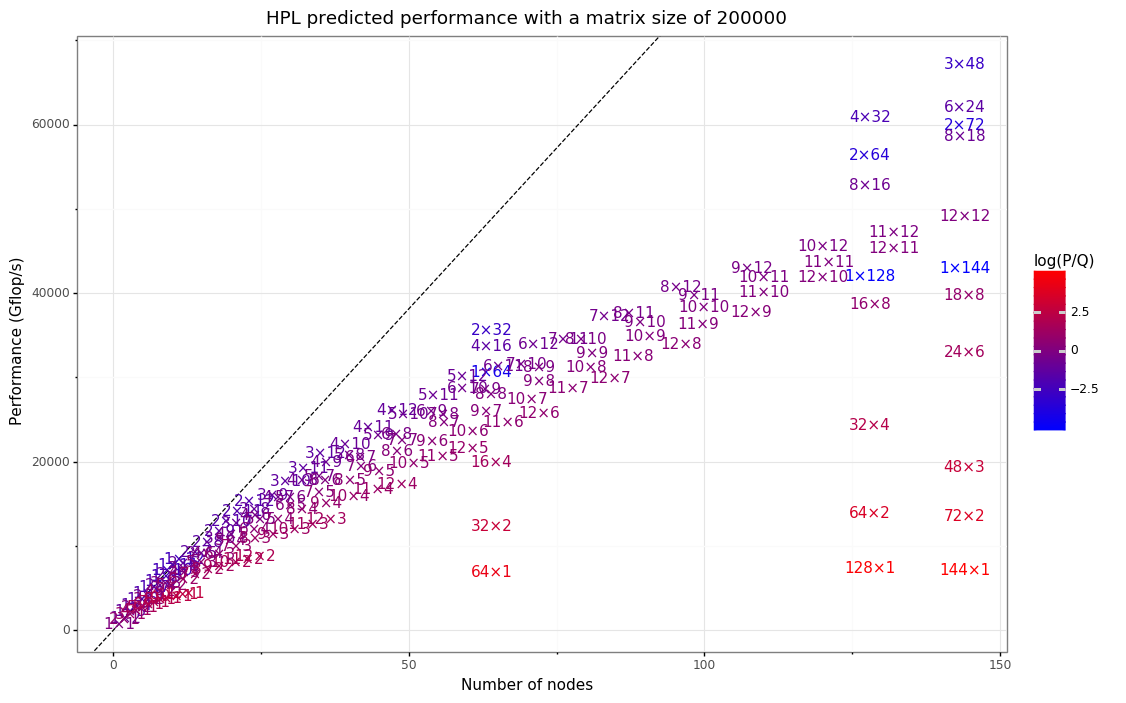

<ggplot: (8754364320285)>

In [7]:
txt = df.groupby(['geometry', 'nb_nodes', 'squareness', 'proc_p', 'proc_q'])[['gflops', 'time', 'simulation_time']].mean().reset_index()
txt['txt'] = txt['geometry'] # + '=' + txt['nb_nodes'].astype(str)
ggplot(txt) +\
    aes(x='nb_nodes', y='gflops', color='squareness', group='geometry') +\
    theme_bw() +\
    geom_abline(slope=df[df.nb_nodes==1].gflops, intercept=0, linetype='dashed') +\
    xlab('Number of nodes') +\
    ylab('Performance (Gflop/s)') +\
    labs(color='log(P/Q)') +\
    ggtitle(f'HPL predicted performance with a matrix size of {df["matrix_size"].max()}') +\
    geom_text(aes(label='txt')) +\
    scale_color_gradient2(low = 'blue', mid = 'purple', high = 'red', midpoint=0)

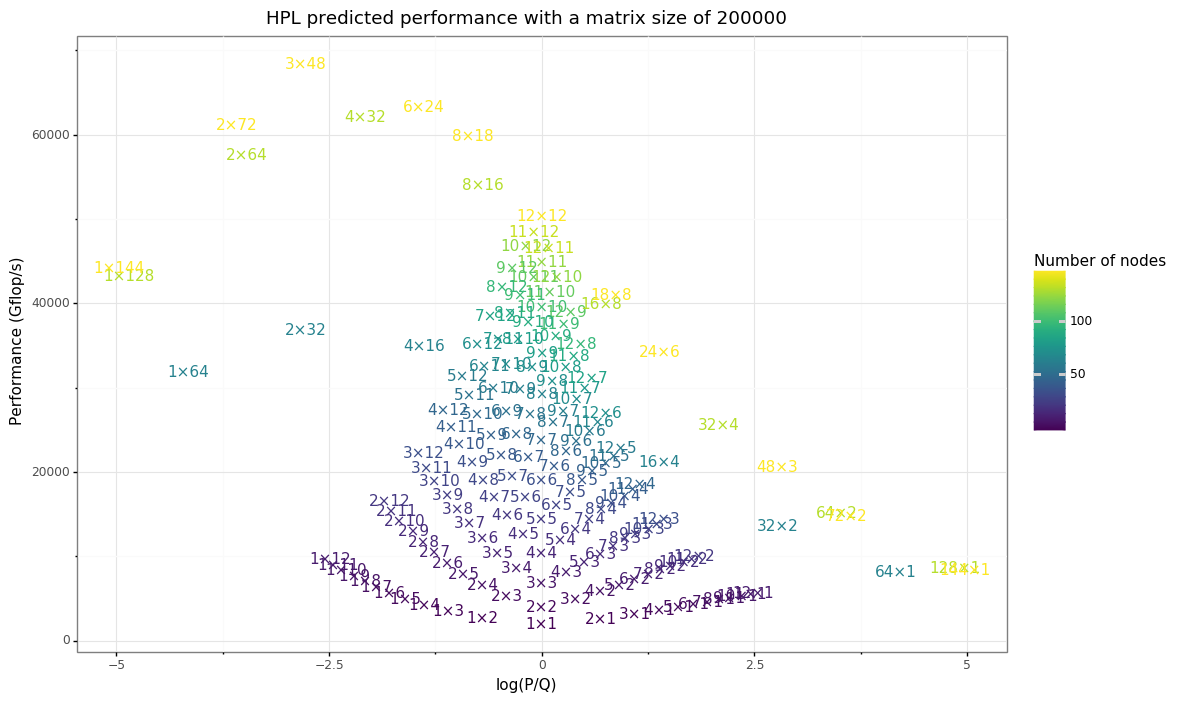

<ggplot: (8754361659719)>

In [8]:
ggplot(df) +\
    aes(x='squareness', y='gflops', color='nb_nodes', group='geometry') +\
    theme_bw() +\
    xlab('log(P/Q)') +\
    ylab('Performance (Gflop/s)') +\
    labs(color='Number of nodes') +\
    ggtitle(f'HPL predicted performance with a matrix size of {df["matrix_size"].max()}') +\
    geom_text(txt, aes(label='txt'), position=position_nudge(y=1200))

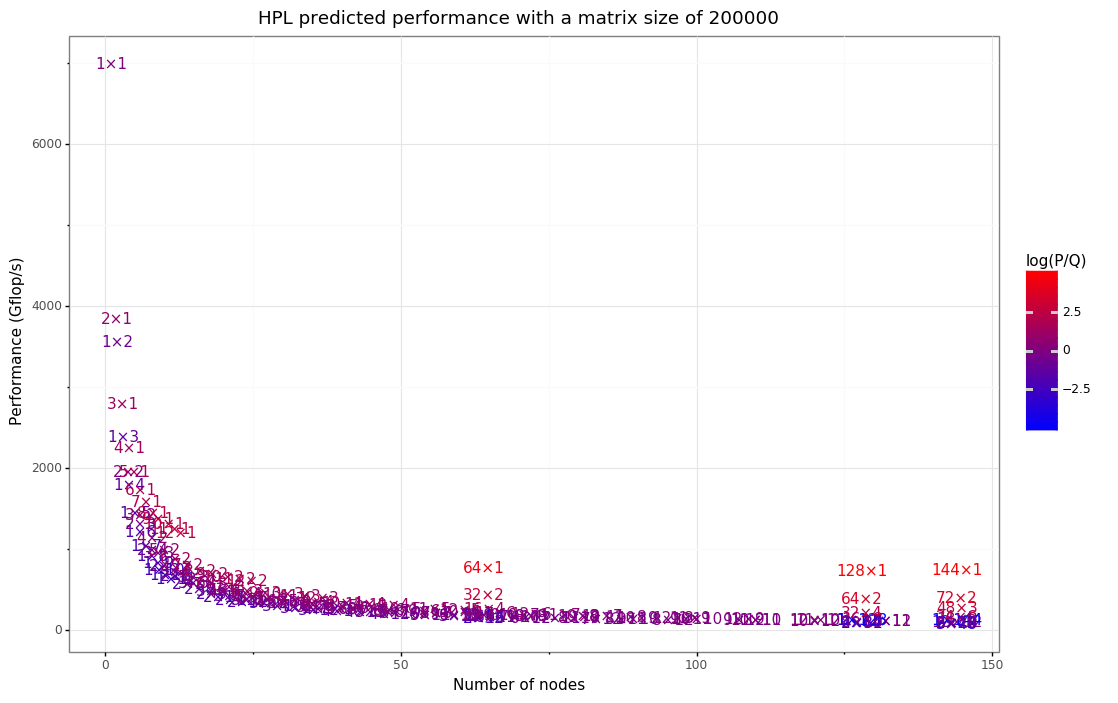

<ggplot: (-9223363282486060081)>

In [9]:
ggplot(txt) +\
    aes(x='nb_nodes', y='time', color='squareness', group='geometry') +\
    theme_bw() +\
    xlab('Number of nodes') +\
    ylab('Performance (Gflop/s)') +\
    labs(color='log(P/Q)') +\
    ggtitle(f'HPL predicted performance with a matrix size of {df["matrix_size"].max()}') +\
    geom_text(aes(label='txt')) +\
    scale_color_gradient2(low = 'blue', mid = 'purple', high = 'red', midpoint=0)

## Simulation time

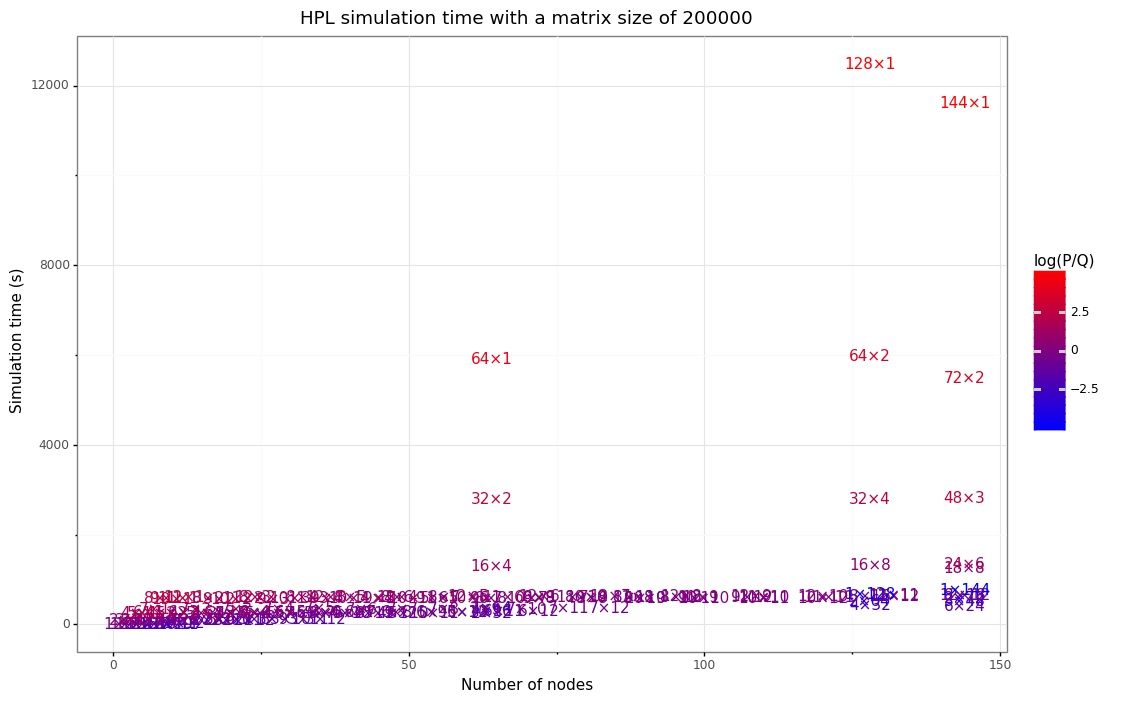

<ggplot: (8754361528247)>

In [10]:
from numpy import mean, std

ggplot(txt) +\
    aes(x='nb_nodes', y='simulation_time', color='squareness', group='geometry') +\
    theme_bw() +\
    xlab('Number of nodes') +\
    ylab('Simulation time (s)') +\
    labs(color='log(P/Q)') +\
    ggtitle(f'HPL simulation time with a matrix size of {df["matrix_size"].max()}') +\
    geom_text(aes(label='txt')) +\
    scale_color_gradient2(low = 'blue', mid = 'purple', high = 'red', midpoint=0)

## Predicting the performance with P and Q

In [11]:
def compute_alt_vars(df):
    df['nb_nodes'] = df['proc_p'] * df['proc_q']
    df['log_p'] = log(df['proc_p'])
    df['log_q'] = log(df['proc_q'])
    df['p2'] = df['proc_p'] ** 2
    df['q2'] = df['proc_q'] ** 2
    df['nb_nodes_inv'] = 1/df['nb_nodes']
    df['p_inv'] = 1/df['proc_p']
    df['q_inv'] = 1/df['proc_q']

compute_alt_vars(df)

In [12]:
import itertools
def powerset(iterable):
    '''
    powerset([1,2,3]) --> (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)
    Taken from https://docs.python.org/3/library/itertools.html#itertools-recipes<Paste>
    '''
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(1, len(s)+1))

variables = ['proc_p', 'proc_q', 'log_p', 'log_q', 'nb_nodes', 'p2', 'q2', 'nb_nodes_inv', 'p_inv', 'q_inv']
combinations = list(powerset(variables))
regressions = []
print(f'Testing {len(combinations)} models')
for combi in combinations:
    formula = f'time ~ {"+".join(combi)}'
    reg = ols(formula, df).fit()
    regressions.append({'BIC': reg.bic, 'AIC': reg.aic, 'R2': reg.rsquared, 'formula': formula, 'variables': tuple(combi), 'nb_variables': len(combi)})

regressions = pandas.DataFrame(regressions).sort_values(by='BIC')
regressions

Testing 1023 models


,BIC,AIC,R2,formula,variables,nb_variables
1006,948.094310,919.978634,0.999979,time ~ proc_q+log_p+log_q+nb_nodes+p2+nb_nodes...,"(proc_q, log_p, log_q, nb_nodes, p2, nb_nodes_...",8
1021,952.081864,920.842225,0.999979,time ~ proc_q+log_p+log_q+nb_nodes+p2+q2+nb_no...,"(proc_q, log_p, log_q, nb_nodes, p2, q2, nb_no...",9
1015,952.970425,921.730785,0.999979,time ~ proc_p+proc_q+log_p+log_q+nb_nodes+p2+n...,"(proc_p, proc_q, log_p, log_q, nb_nodes, p2, n...",9
976,953.957178,925.841503,0.999978,time ~ proc_p+proc_q+log_p+log_q+nb_nodes+nb_n...,"(proc_p, proc_q, log_p, log_q, nb_nodes, nb_no...",8
1022,957.110189,922.746585,0.999979,time ~ proc_p+proc_q+log_p+log_q+nb_nodes+p2+q...,"(proc_p, proc_q, log_p, log_q, nb_nodes, p2, q...",10
...,...,...,...,...,...,...
6,2720.425621,2714.177693,0.009677,time ~ q2,"(q2,)",1
0,2721.227665,2714.979737,0.004938,time ~ proc_p,"(proc_p,)",1
5,2722.043288,2715.795360,0.000095,time ~ p2,"(p2,)",1
15,2724.499822,2715.127930,0.015846,time ~ proc_p+q2,"(proc_p, q2)",2


In [13]:
formulas = []
for nvar in range(1, regressions['nb_variables'].max()+1):
    reg = regressions[regressions['nb_variables'] == nvar]
    reg = reg[reg['BIC'] == reg['BIC'].min()]
    assert len(reg) == 1
    reg = list(reg.iterrows())[0][1]
    print(f'BIC = {reg.BIC:7.1f}  | {reg.formula}')
    formulas.append(reg.formula)

BIC =  2162.8  | time ~ nb_nodes_inv
BIC =  1346.0  | time ~ nb_nodes_inv+q_inv
BIC =  1054.1  | time ~ nb_nodes_inv+p_inv+q_inv
BIC =  1038.8  | time ~ p2+nb_nodes_inv+p_inv+q_inv
BIC =  1024.0  | time ~ log_p+p2+nb_nodes_inv+p_inv+q_inv
BIC =  1004.3  | time ~ proc_p+log_p+q2+nb_nodes_inv+p_inv+q_inv
BIC =   975.6  | time ~ proc_q+log_p+log_q+p2+nb_nodes_inv+p_inv+q_inv
BIC =   948.1  | time ~ proc_q+log_p+log_q+nb_nodes+p2+nb_nodes_inv+p_inv+q_inv
BIC =   952.1  | time ~ proc_q+log_p+log_q+nb_nodes+p2+q2+nb_nodes_inv+p_inv+q_inv
BIC =   957.1  | time ~ proc_p+proc_q+log_p+log_q+nb_nodes+p2+q2+nb_nodes_inv+p_inv+q_inv


Alright, the formula `time ~ nb_nodes_inv+p_inv+q_inv` seems pretty good, but let's test all of them.

                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     4466.
Date:                Wed, 08 Apr 2020   Prob (F-statistic):          6.45e-122
Time:                        14:42:43   Log-Likelihood:                -1076.3
No. Observations:                 168   AIC:                             2157.
Df Residuals:                     166   BIC:                             2163.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      138.0738     13.014     10.609   

OK


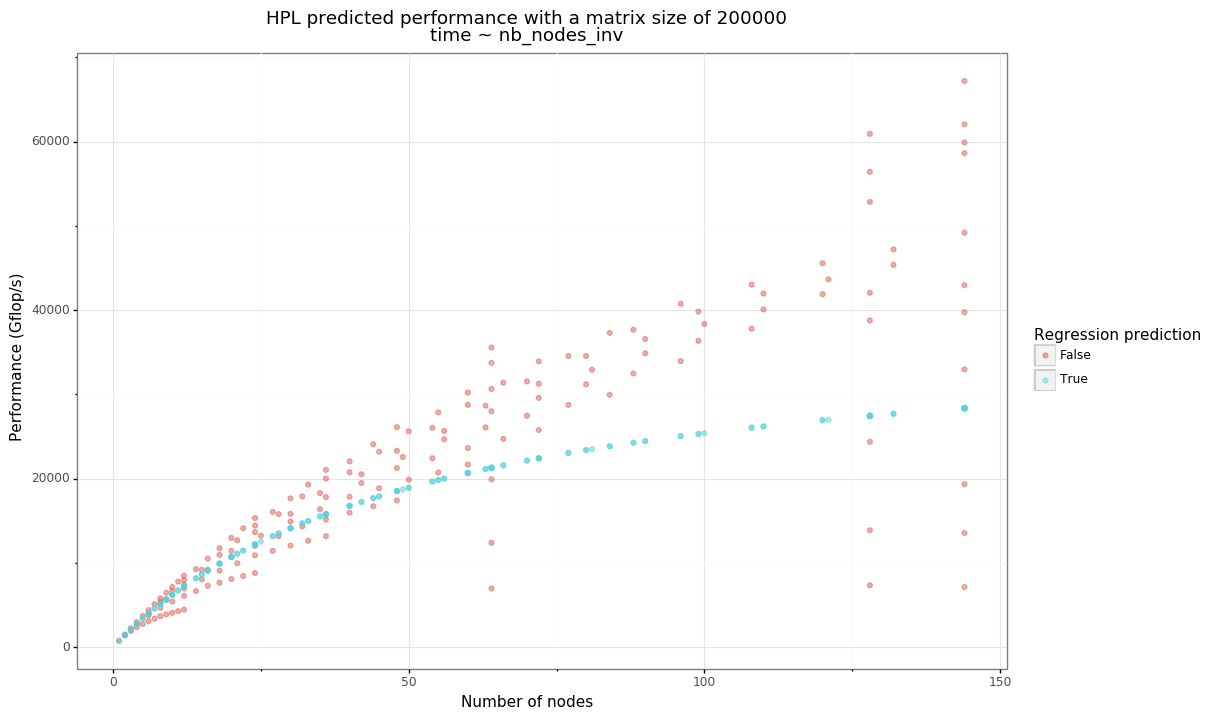

<ggplot: (8754461713342)>
                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.067e+05
Date:                Wed, 08 Apr 2020   Prob (F-statistic):          2.75e-295
Time:                        14:42:44   Log-Likelihood:                -665.32
No. Observations:                 168   AIC:                             1337.
Df Residuals:                     165   BIC:                             1346.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       19.801

OK


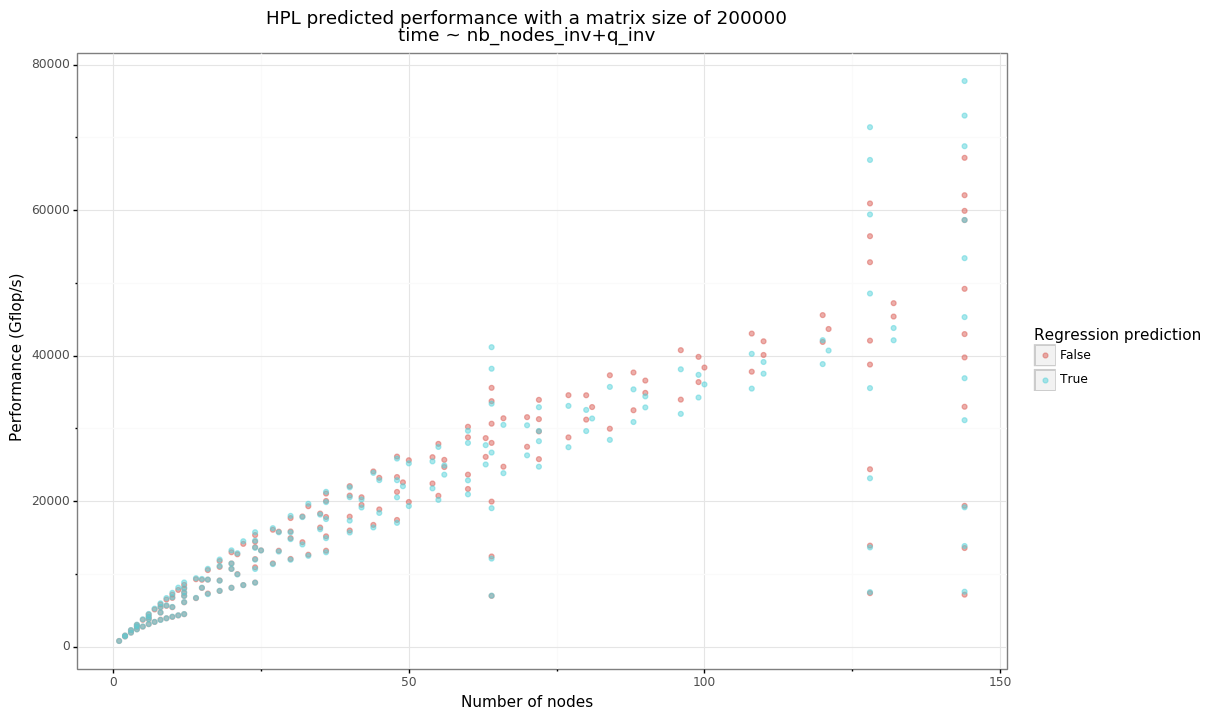

<ggplot: (8754359973212)>
                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.191e+06
Date:                Wed, 08 Apr 2020   Prob (F-statistic):               0.00
Time:                        14:42:44   Log-Likelihood:                -516.80
No. Observations:                 168   AIC:                             1042.
Df Residuals:                     164   BIC:                             1054.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.540

OK


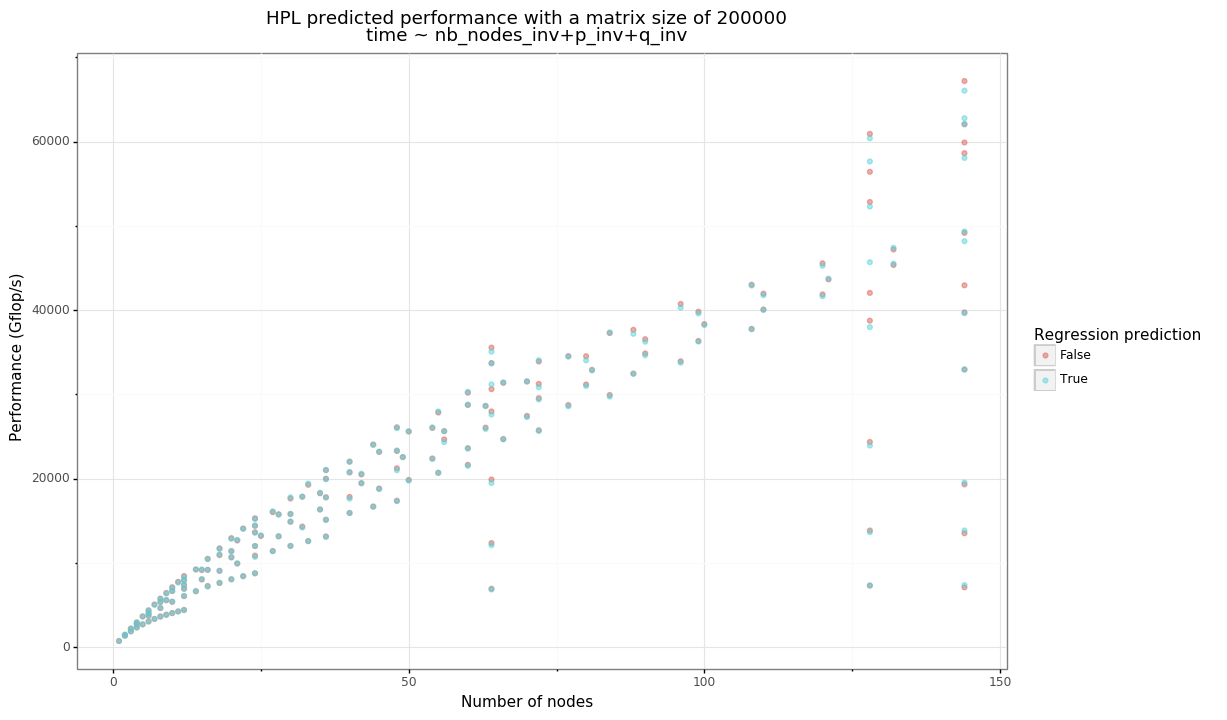

<ggplot: (8754364323094)>
                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.003e+06
Date:                Wed, 08 Apr 2020   Prob (F-statistic):               0.00
Time:                        14:42:45   Log-Likelihood:                -506.60
No. Observations:                 168   AIC:                             1023.
Df Residuals:                     163   BIC:                             1039.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.142

OK


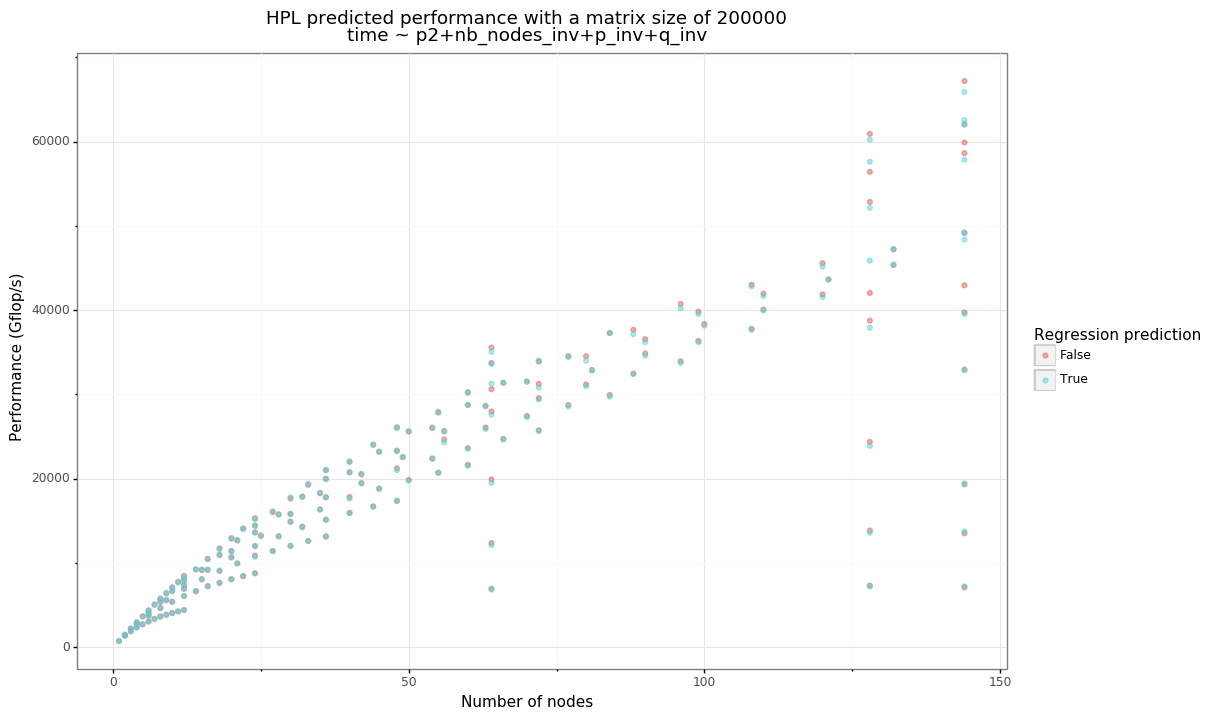

<ggplot: (-9223363282494867196)>
                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.977e+05
Date:                Wed, 08 Apr 2020   Prob (F-statistic):               0.00
Time:                        14:42:45   Log-Likelihood:                -496.63
No. Observations:                 168   AIC:                             1005.
Df Residuals:                     162   BIC:                             1024.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      

OK


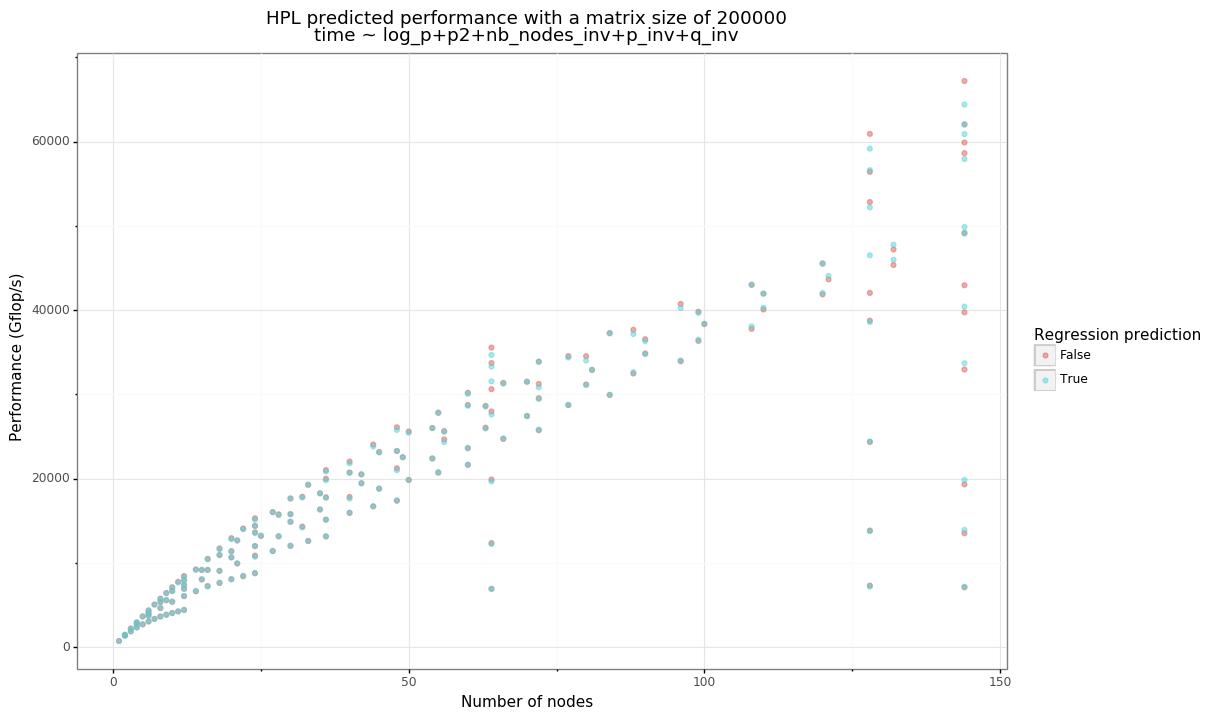

<ggplot: (8754359906536)>
                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.621e+05
Date:                Wed, 08 Apr 2020   Prob (F-statistic):               0.00
Time:                        14:42:46   Log-Likelihood:                -484.19
No. Observations:                 168   AIC:                             982.4
Df Residuals:                     161   BIC:                             1004.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       24.124

OK


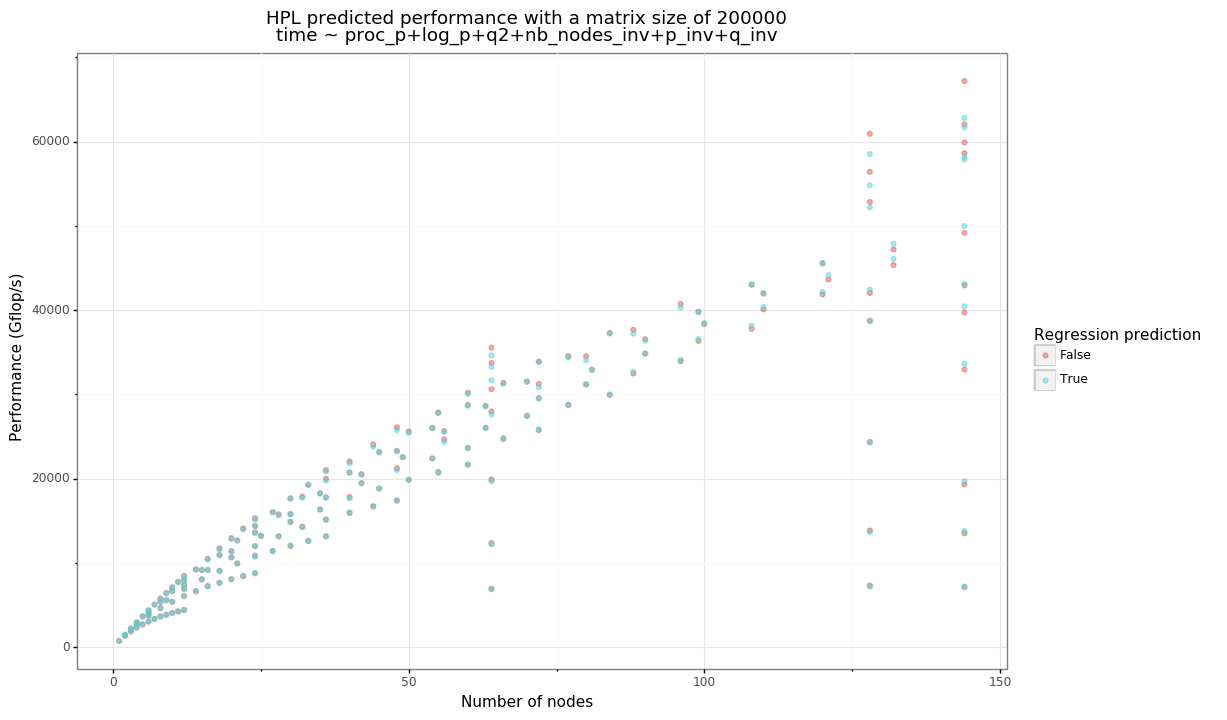

<ggplot: (-9223363282494895367)>
                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.977e+05
Date:                Wed, 08 Apr 2020   Prob (F-statistic):               0.00
Time:                        14:42:46   Log-Likelihood:                -467.33
No. Observations:                 168   AIC:                             950.7
Df Residuals:                     160   BIC:                             975.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      

OK


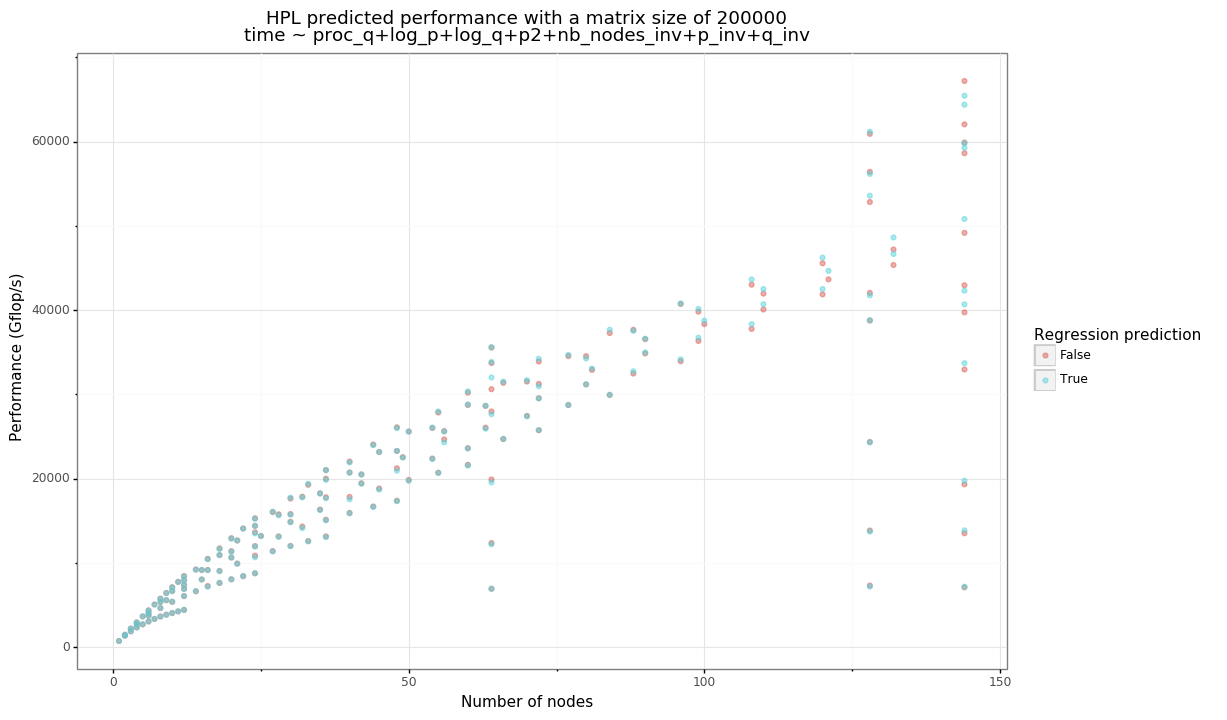

<ggplot: (8754359941468)>
                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.481e+05
Date:                Wed, 08 Apr 2020   Prob (F-statistic):               0.00
Time:                        14:42:47   Log-Likelihood:                -450.99
No. Observations:                 168   AIC:                             920.0
Df Residuals:                     159   BIC:                             948.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       61.854

OK


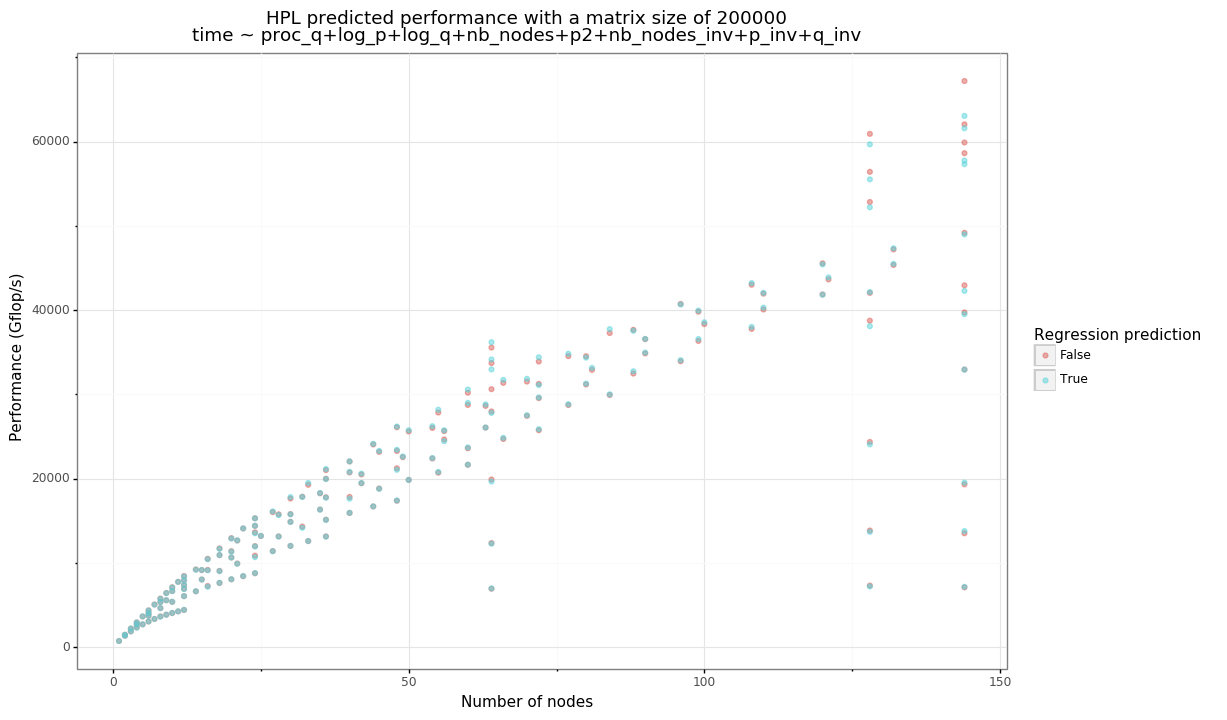

<ggplot: (-9223363282494866372)>
                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.432e+05
Date:                Wed, 08 Apr 2020   Prob (F-statistic):               0.00
Time:                        14:42:47   Log-Likelihood:                -450.42
No. Observations:                 168   AIC:                             920.8
Df Residuals:                     158   BIC:                             952.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      

OK


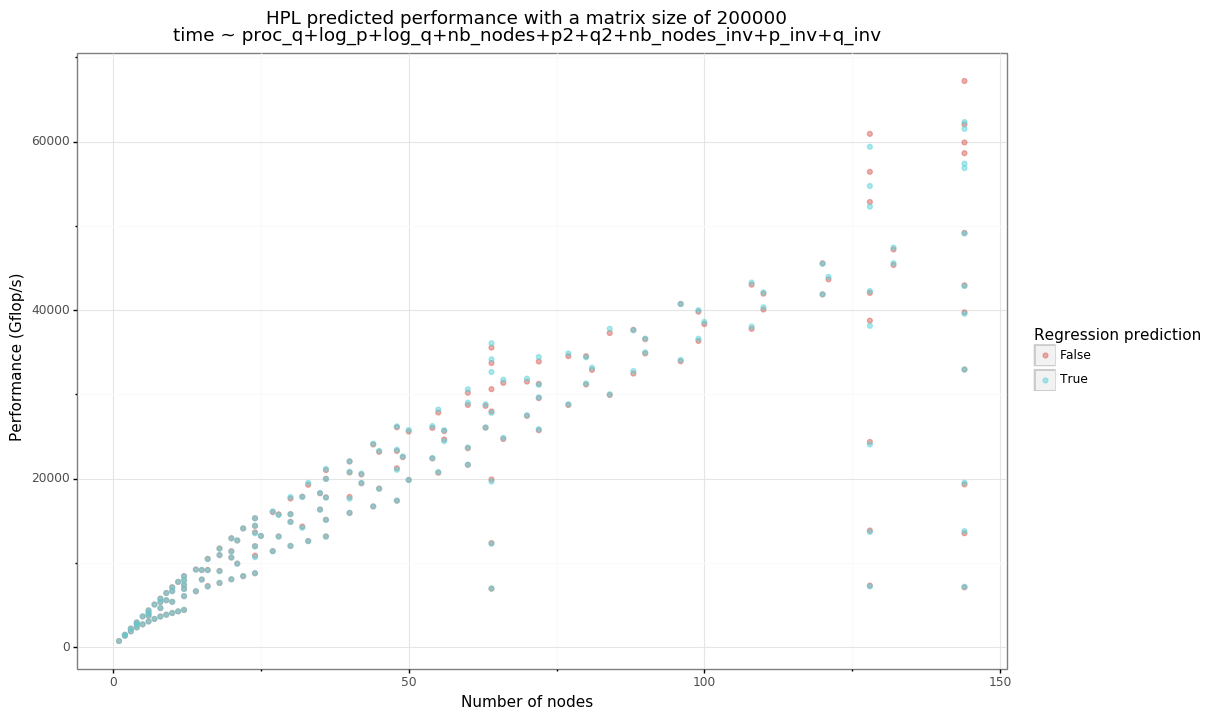

<ggplot: (8754359815218)>
                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.545e+05
Date:                Wed, 08 Apr 2020   Prob (F-statistic):               0.00
Time:                        14:42:48   Log-Likelihood:                -450.37
No. Observations:                 168   AIC:                             922.7
Df Residuals:                     157   BIC:                             957.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       64.434

OK


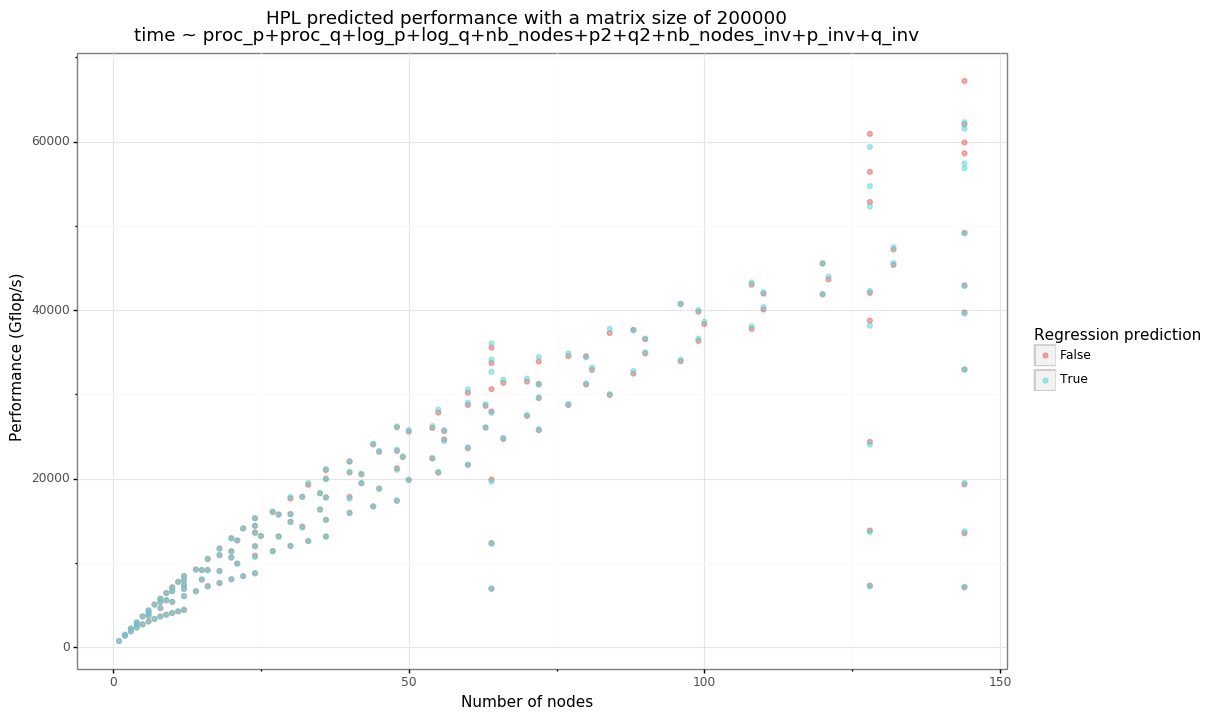

<ggplot: (-9223363282494896433)>


In [14]:
import sys

def do_regression(df, formula, test_df=None, show_summary=False, warning=False):
    if test_df is None:
        tmp = df.copy()
    else:
        tmp = test_df.copy()
    reg = ols(formula, df).fit()
    if show_summary:
        print(reg.summary())

    compute_alt_vars(tmp)
    tmp['n3'] = tmp.matrix_size ** 3
    tmp['n2'] = tmp.matrix_size ** 2
    p = reg.params
    tmp['pred'] = p.Intercept
    for col, val in p.items():
        if col == 'Intercept':
            continue
        tmp['pred'] += val * tmp[col]
    tmp['pred_gflops'] = (2/3*tmp['n3'] + 2*tmp['n2']) / tmp['pred'] * 1e-9
    if warning:
        len_neg = len(tmp[tmp['pred_gflops'] < 0])
        len_high = len(tmp[tmp['pred_gflops'] > df['gflops'].max()*10])
        if len_neg > 0 or len_high > 0:
            sys.stderr.write(f'WARNING: {len_neg:3d} negative performance | {len_high:3d} absurdly high performance\n')
        else:
            sys.stderr.write('OK\n')

    if test_df is None:
        tmp = tmp.melt(id_vars=['nb_nodes', 'geometry'], value_vars=['gflops', 'pred_gflops'])
        tmp['regression'] = tmp['variable'] == 'pred_gflops'
    else:
        tmp['value'] = tmp['pred_gflops']
        tmp['regression'] = True
    return tmp

for form in formulas:
    tmp_df = do_regression(df, form, warning=True, show_summary=True)
    plot = ggplot(tmp_df) +\
        aes(x='nb_nodes', y='value', color='regression') +\
        theme_bw() +\
        geom_point(alpha=0.5) +\
        xlab('Number of nodes') +\
        ylab('Performance (Gflop/s)') +\
        labs(color='Regression prediction') +\
        ggtitle(f'HPL predicted performance with a matrix size of {df["matrix_size"].max()}\n{form}')
    print(plot)

## Extrapolating the predictions

In [15]:
l = []
for p in range(1, 100):
    for q in range(1, 100):
        l.append((p, q))

gen = pandas.DataFrame(l, columns=['proc_p', 'proc_q'])
gen['matrix_size'] = df.matrix_size.max()
predictions = []
for form in formulas:
    tmp_df = do_regression(df, form, test_df=gen, warning=True, show_summary=True)
    predictions.append((form, tmp_df))

                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     4466.
Date:                Wed, 08 Apr 2020   Prob (F-statistic):          6.45e-122
Time:                        14:42:48   Log-Likelihood:                -1076.3
No. Observations:                 168   AIC:                             2157.
Df Residuals:                     166   BIC:                             2163.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      138.0738     13.014     10.609   

OK
OK
OK
OK
OK
OK
OK


                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.481e+05
Date:                Wed, 08 Apr 2020   Prob (F-statistic):               0.00
Time:                        14:42:48   Log-Likelihood:                -450.99
No. Observations:                 168   AIC:                             920.0
Df Residuals:                     159   BIC:                             948.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       61.8549      5.388     11.479   

OK
OK
OK


In [16]:
%load_ext rpy2.ipython

In [17]:
%%R
library(ggplot2)
library(dplyr)
library(patchwork)
R.version.string

R[write to console]: 
Attachement du package : ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




[1] "R version 3.5.2 (2018-12-20)"


In [18]:
for form, tmp_df in predictions:
    tmp_df['formula'] = form
R_df = pandas.concat([tmp_df for form, tmp_df in predictions])
R_df = R_df[['proc_p', 'proc_q', 'nb_nodes', 'pred_gflops', 'formula']]
R_df.head()

,proc_p,proc_q,nb_nodes,pred_gflops,formula
0,1,1,1,726.853081,time ~ nb_nodes_inv
1,1,2,2,1426.856854,time ~ nb_nodes_inv
2,1,3,3,2101.472025,time ~ nb_nodes_inv
3,1,4,4,2752.055231,time ~ nb_nodes_inv
4,1,5,5,3379.868142,time ~ nb_nodes_inv


[1] "time ~ nb_nodes_inv"
[1] "time ~ nb_nodes_inv+q_inv"
[1] "time ~ nb_nodes_inv+p_inv+q_inv"
[1] "time ~ p2+nb_nodes_inv+p_inv+q_inv"
[1] "time ~ log_p+p2+nb_nodes_inv+p_inv+q_inv"
[1] "time ~ proc_p+log_p+q2+nb_nodes_inv+p_inv+q_inv"
[1] "time ~ proc_q+log_p+log_q+p2+nb_nodes_inv+p_inv+q_inv"
[1] "time ~ proc_q+log_p+log_q+nb_nodes+p2+nb_nodes_inv+p_inv+q_inv"
[1] "time ~ proc_q+log_p+log_q+nb_nodes+p2+q2+nb_nodes_inv+p_inv+q_inv"
[1] "time ~ proc_p+proc_q+log_p+log_q+nb_nodes+p2+q2+nb_nodes_inv+p_inv+q_inv"


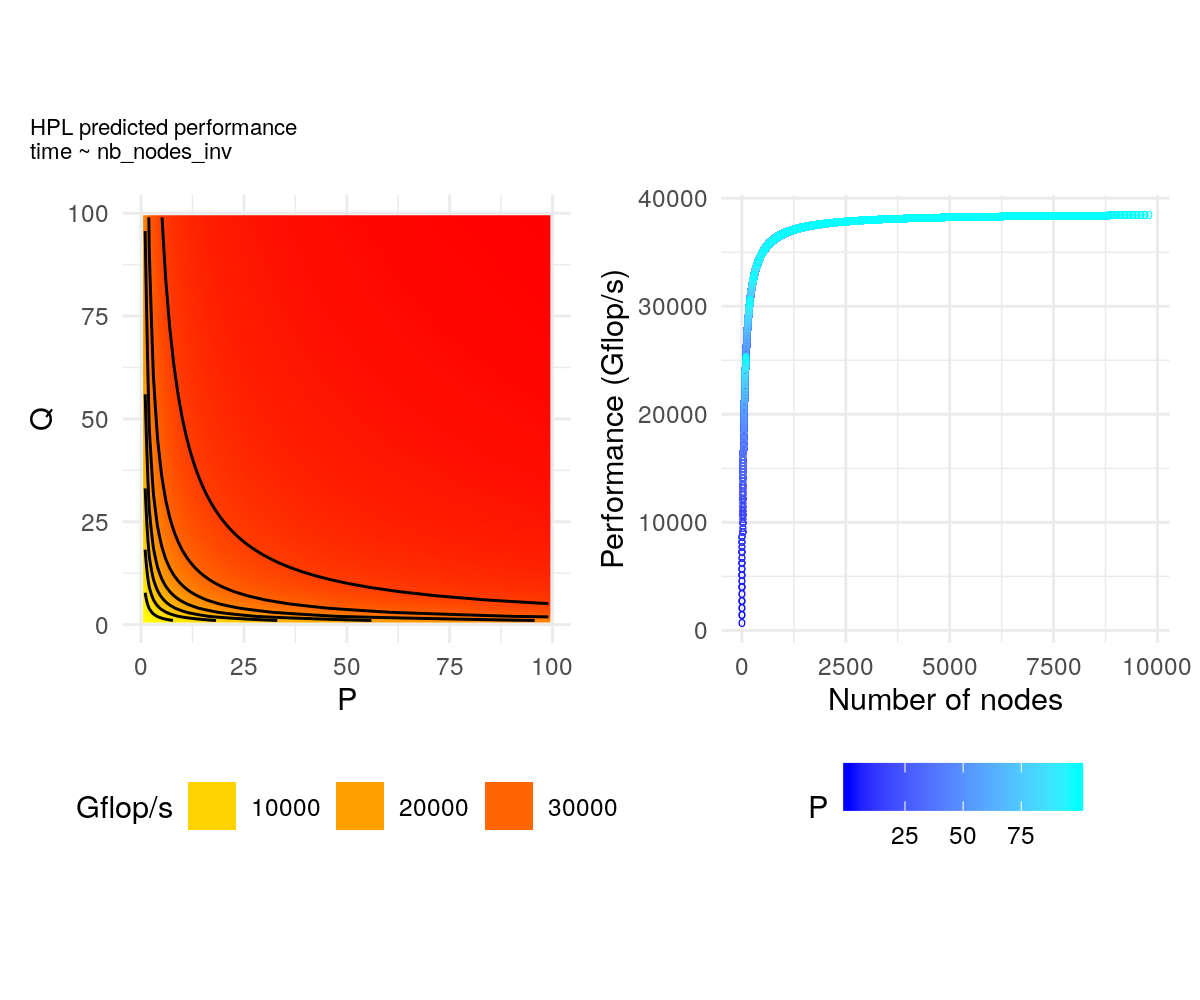

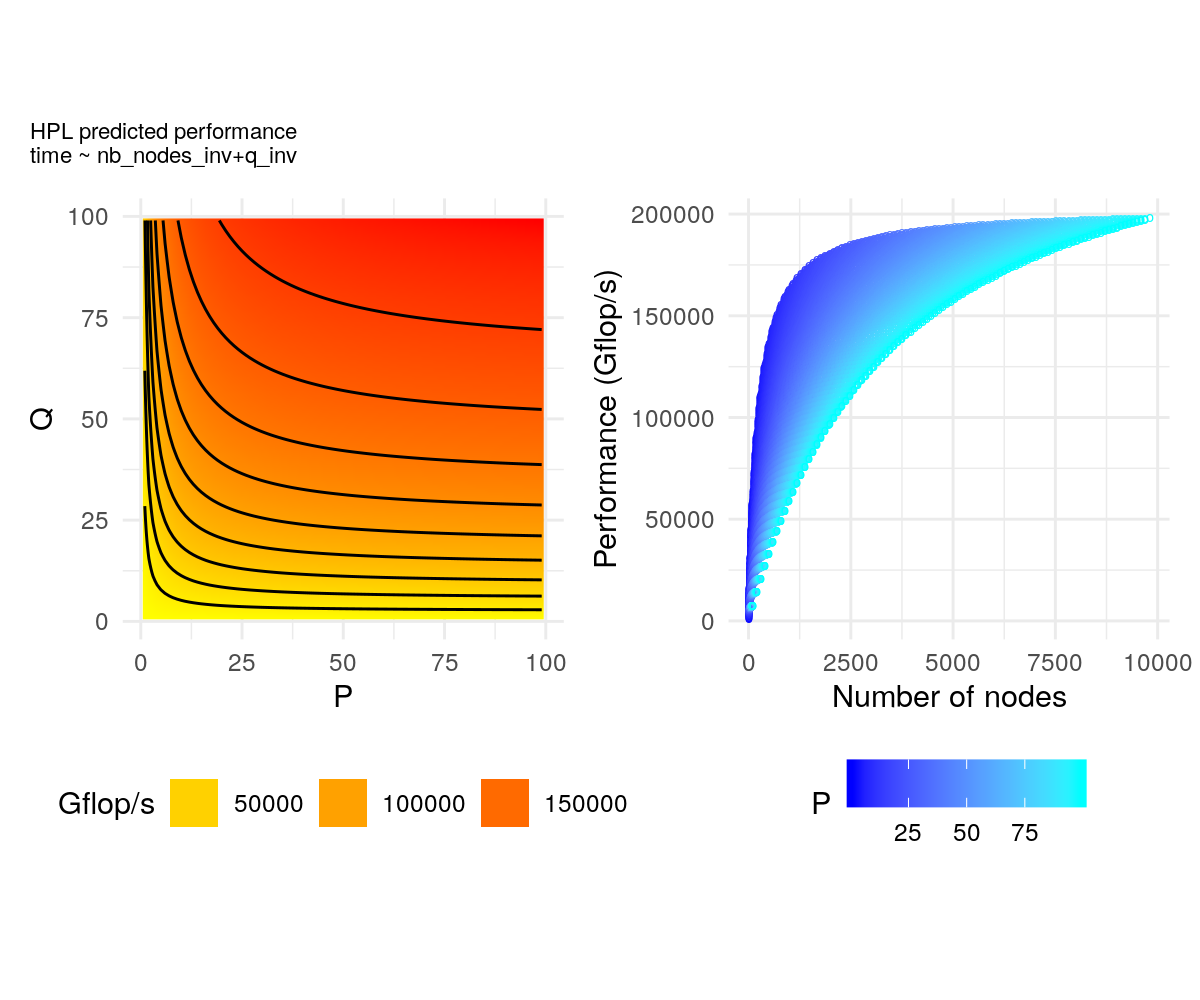

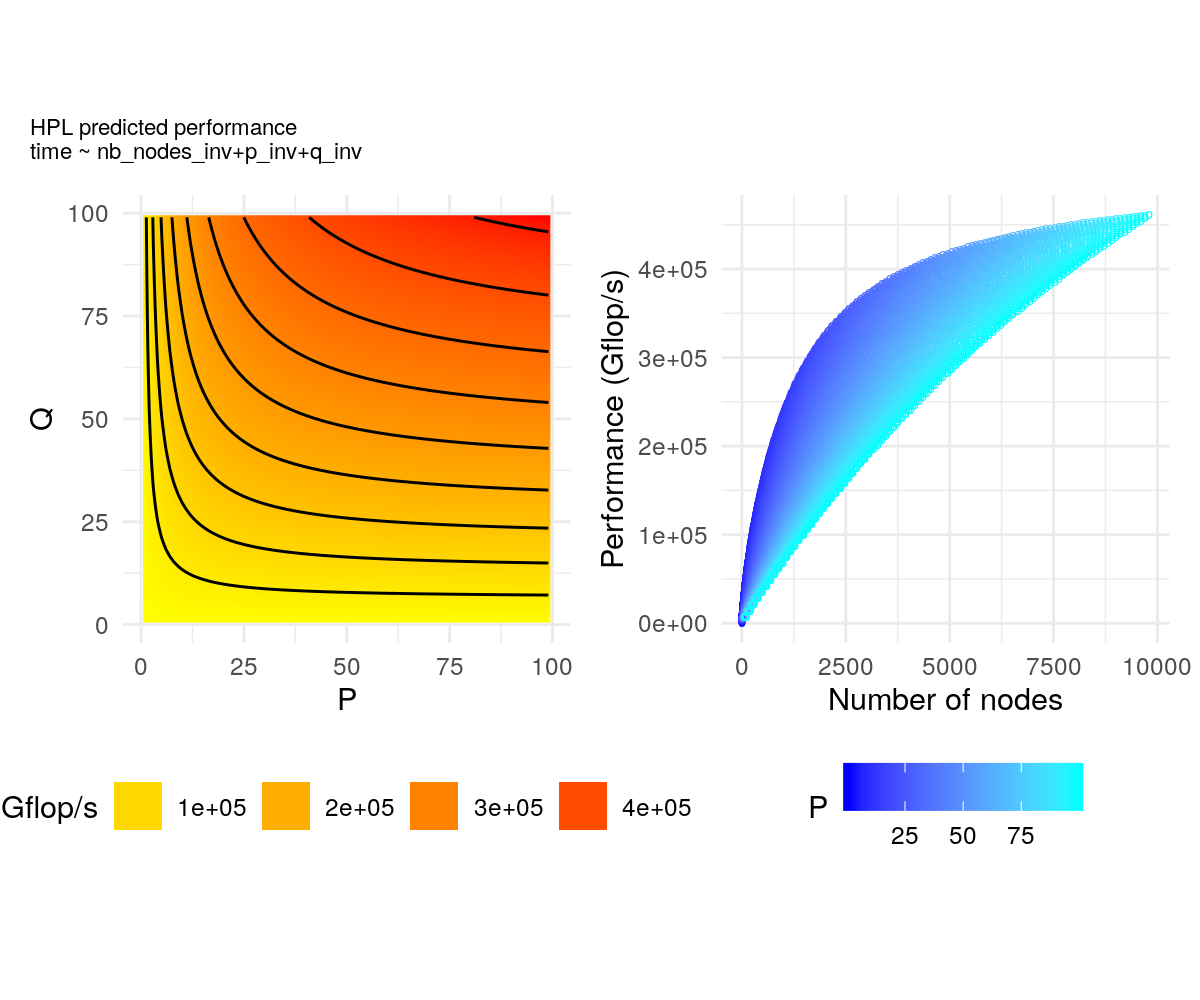

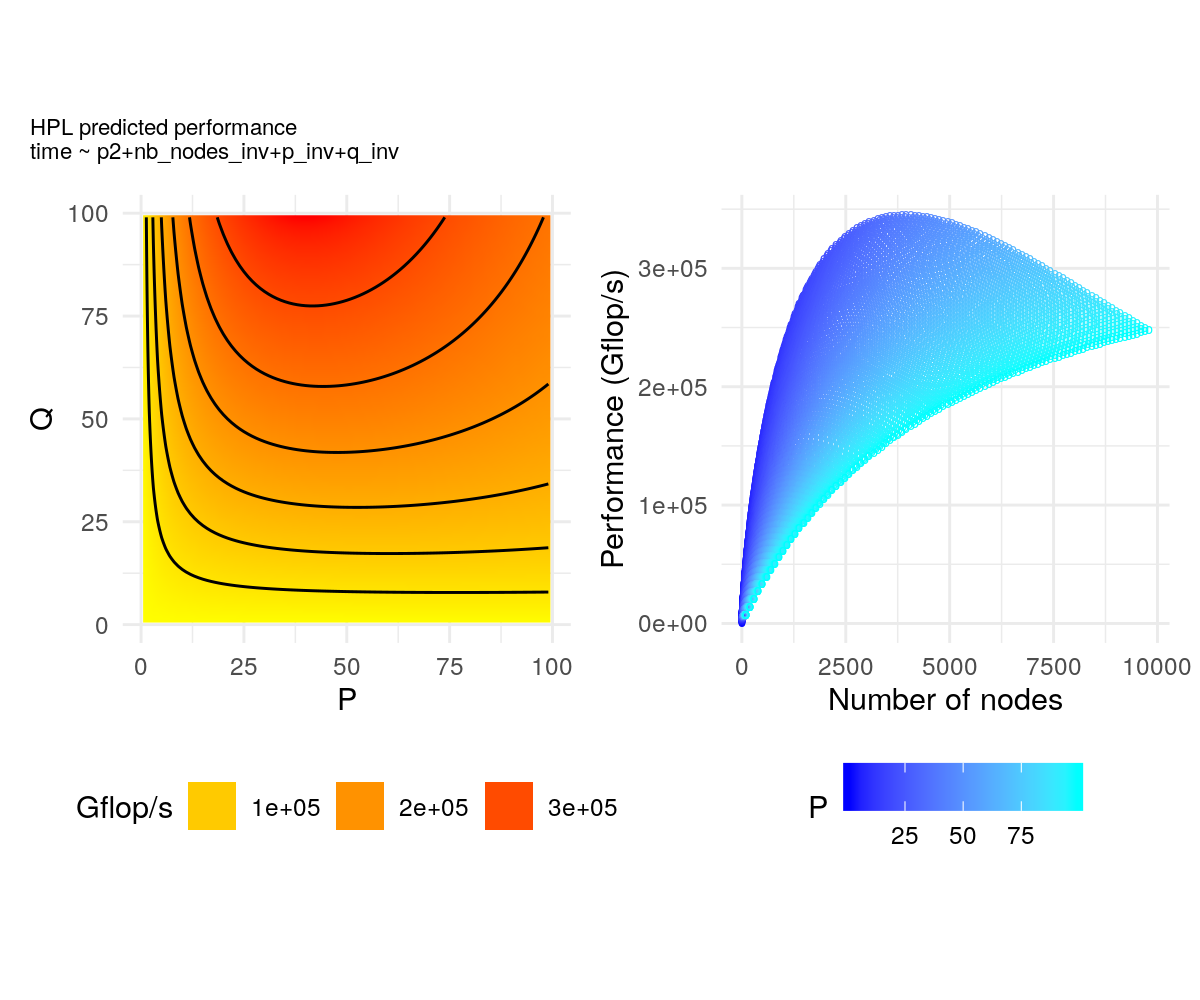

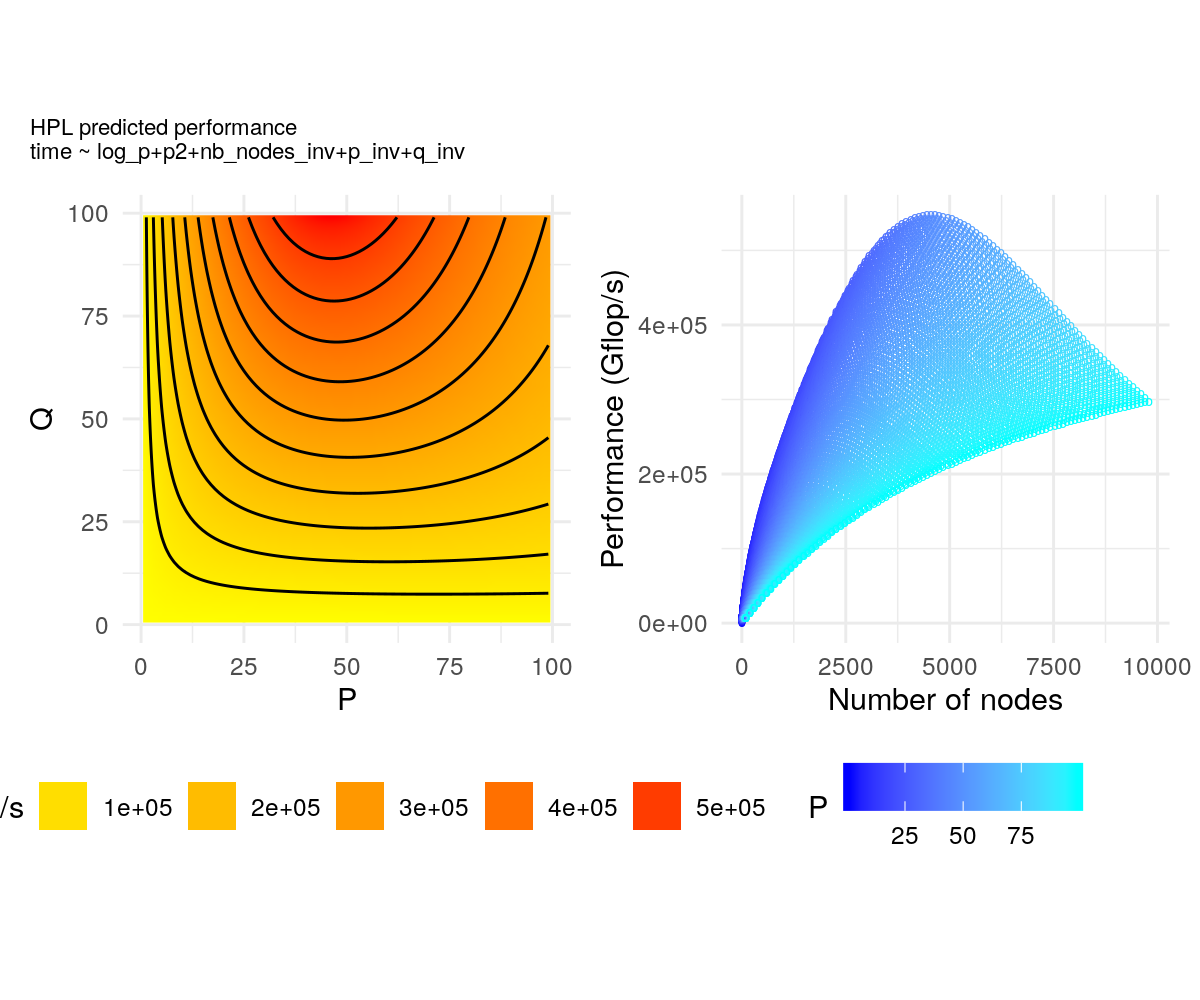

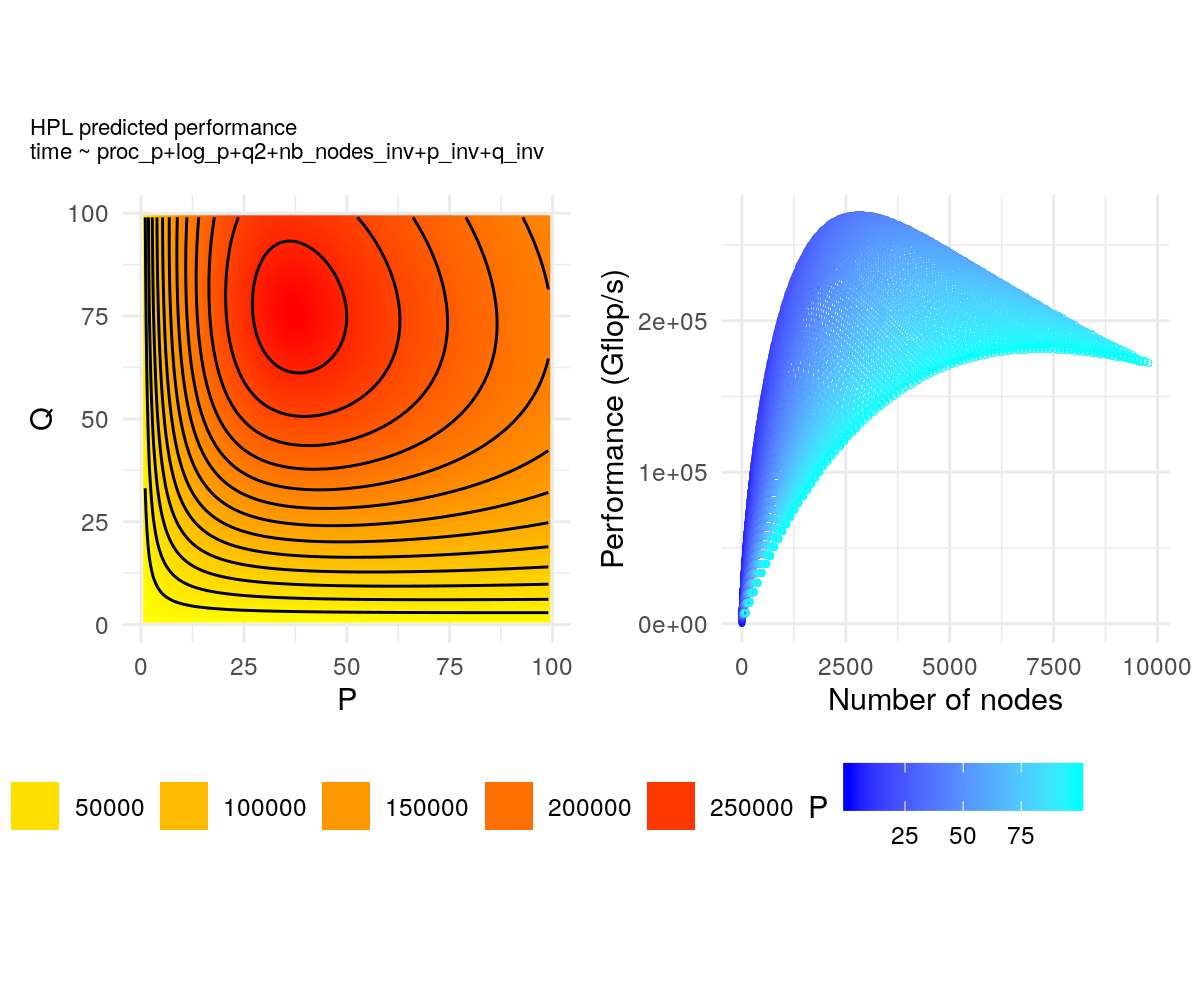

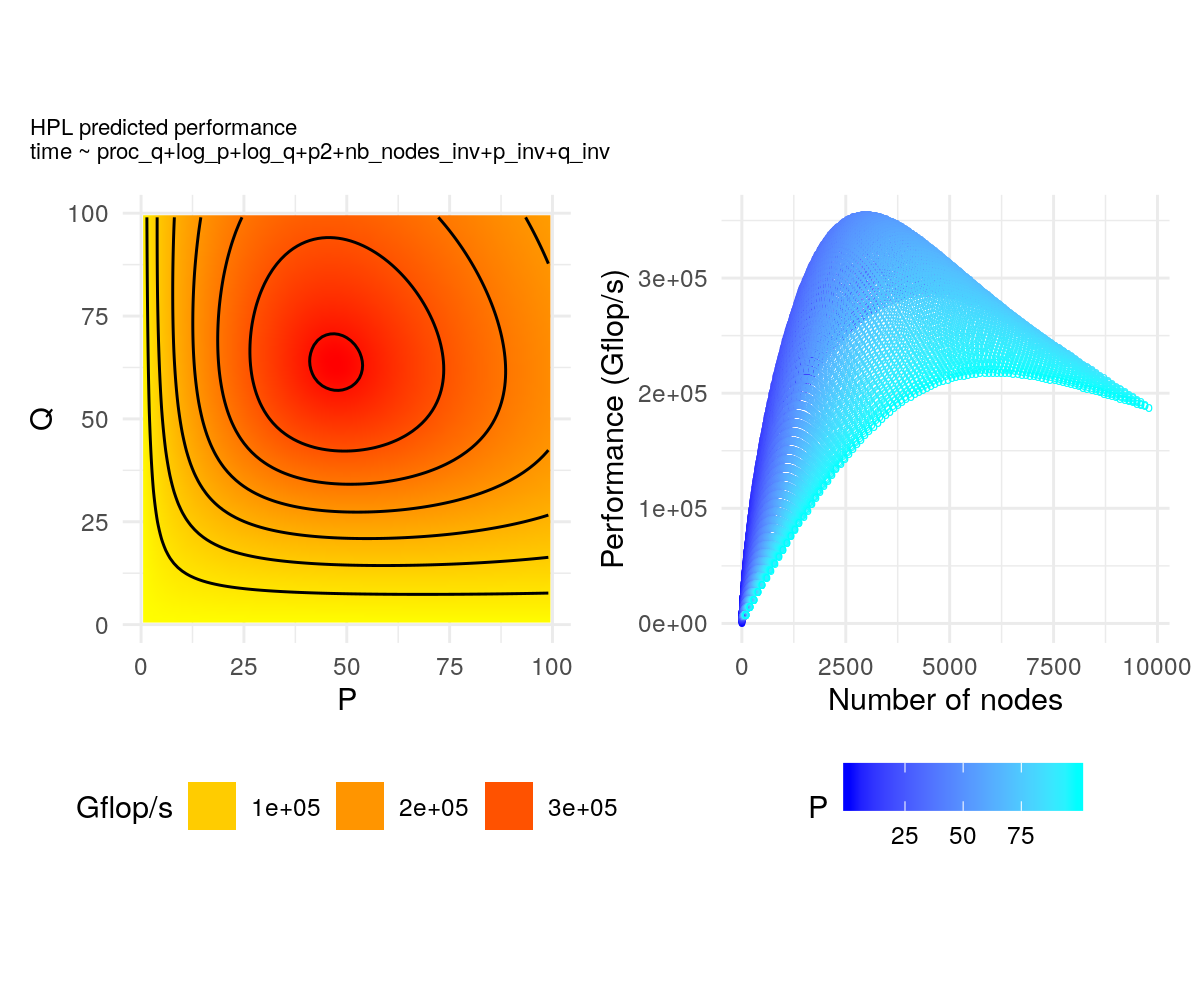

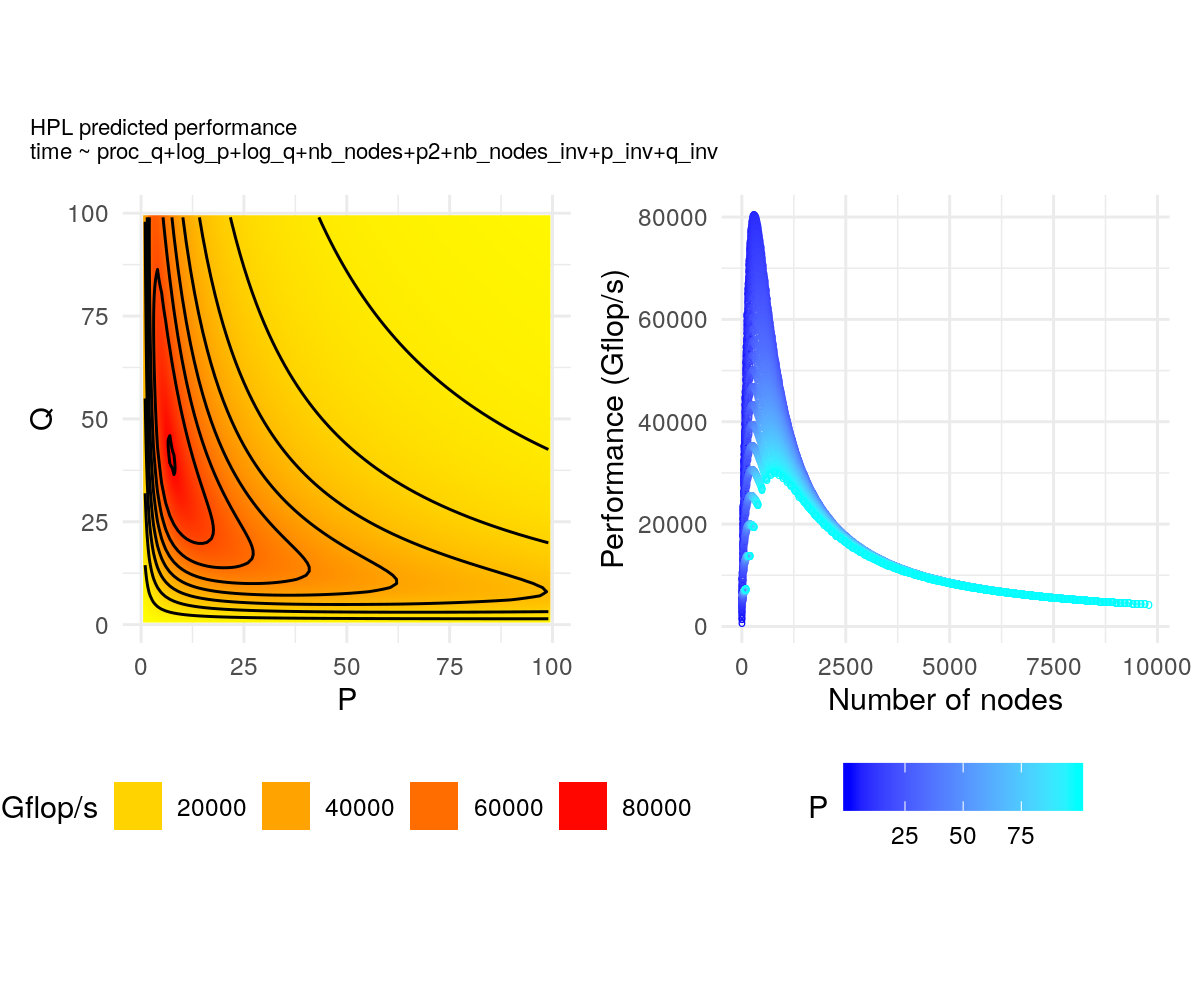

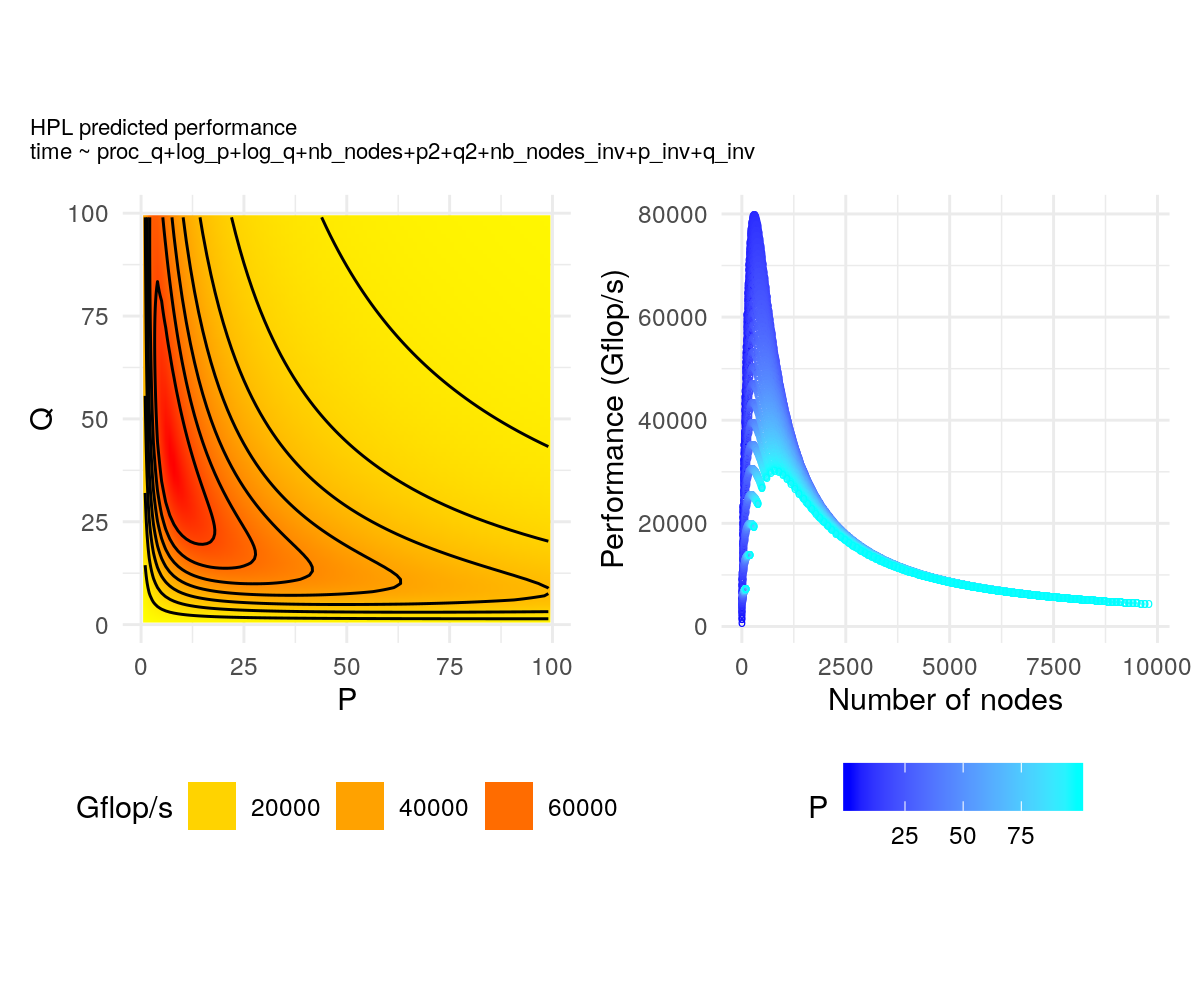

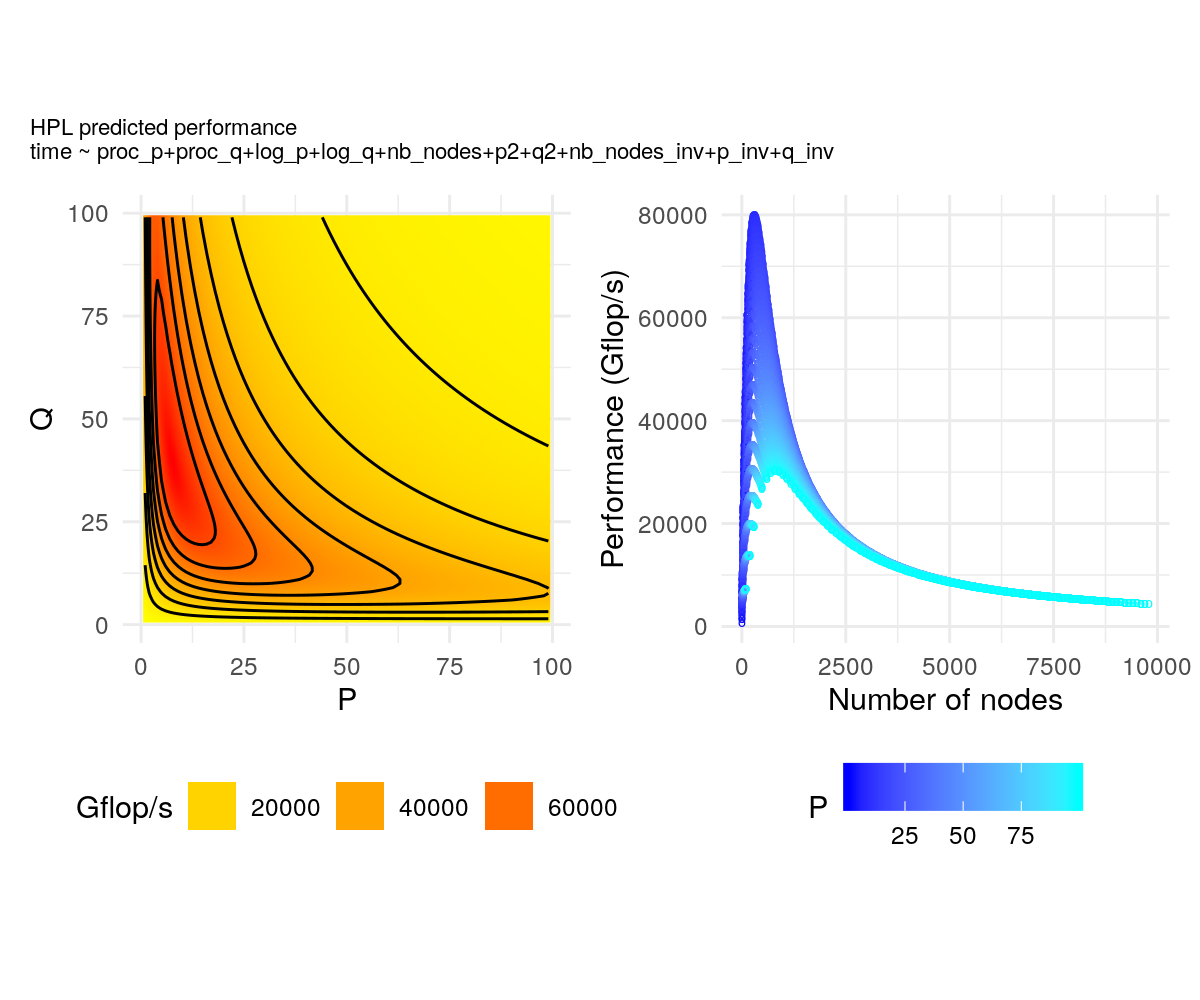

In [19]:
%%R -i R_df -w 6 -h 5 --units in -r 200

do_plot <- function(df, form) {
    plot1 = ggplot(df) +
        aes(x=proc_p, y=proc_q, fill=pred_gflops) +
        geom_raster(interpolate=T) +
        scale_fill_gradient(low = 'yellow', high = 'red', guide = guide_legend()) +
        stat_contour(aes(z=pred_gflops), color='black') +
        xlab('P') +
        ylab('Q') +
        coord_fixed() +
        labs(fill='Gflop/s') +
        theme_minimal() +
        theme(legend.position="bottom")
    plot2 = ggplot(df) +
        aes(x=nb_nodes, y=pred_gflops, color=proc_p) +
        theme_minimal() +
        geom_point(shape='o') +
        xlab('Number of nodes') +
        ylab('Performance (Gflop/s)') +
        labs(color='P') +
        scale_color_gradient(low = '#0000FF', high = '#00FFFF') +
        theme(legend.position="bottom")

    plot_title = paste('HPL predicted performance', form, sep='\n')
    plot = (plot1 + plot2) +
        plot_annotation(title=plot_title, theme = theme(plot.title = element_text(size = 8)))

    return(plot)
}

for(f in unique(R_df$formula)) {
    print(f)
    print(do_plot(R_df %>% filter(formula==f), f))
}